# Séance 2 - Réseau convolutionnel : Proposition de correction

Ce notebook est une proposition de correction pour le TP de la séance 2. Un travail différent peut être correct sans pour autant être identique à celui-là.

Commençons par importer l'ensemble des éléments dont nous aurons besoin.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras

from max_abs_pool import MaxAbsPool2D
from sharpened_cosine_similarity import CosSim2D

from sklearn.model_selection import train_test_split
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (fashion_mnist.load_data())
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)



from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28, 1)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28, 1)
X_test = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28, 1)

label_map = {0: "t-shirt/top", 1: "trouser", 2: "pullover",
             3: "dress", 4: "coat", 5: "sandal",
             6: "shirt", 7: "sneaker", 8: "bag", 9: "ankle boot"}

4422102/4422102 [==============================] - 0s 0us/step


## Sujet D - Sharpened cosine similarity

Dans ce sujet, on souhaite explorer les possibilités d'une nouvelle couche proposée : la couche *Sharpened cosine similarity*. L'idée est de remplacer le produit scalaire de la couche de convolution classique par une autre forme:

$$SCS(s, k) = \text{sign}\left(\langle s, k\rangle\right)\left|\frac{\langle s, k\rangle}{(\|s\| + q)(\|k\|+q)}\right|^p$$

Avec $s$ le signal, la sous-image, et $k$ le kernel, le filtre. Cela ressemble à la similarité cosinus, mais elle est augmenté à la puissance *p* pour la rendre plus sensible.

Il a été observé (voir [ce billet de blog](https://www.rpisoni.dev/posts/cossim-convolution/)) que le filtre *cherche* à trouver dans l'image le pattern qu'il représente : à l'identique comme à l'opposé ! Partant de ce constat, la couche de pooling a été modifiée pour renvoyer la valeur maximum en valeur absolue.

Ces deux couches ne sont pas nativement présente dans Keras. Il a donc fallu exploiter une possibilité de Keras : créer sa propre couche. Cela nécessite de respecter un format précis. Le travail a déjà été réalisé et on peut trouver le résultat [ici](https://github.com/brohrer/sharpened-cosine-similarity). Cependant, la qualité de code et certaines possibilités, ou absence de possibilités, ne me convenaient pas et j'en ai donc fait ma propre version. Voici les deux modifications principales:
1. Alignement des paramètres et noms de paramètres sur l'API Keras, spécifiquement la couche MaxPooling2D et Conv2D.
2. Gestion du cas où le filtre de la couche de MaxPooling n'est pas un carré

L'objectif du notebook n'est pas de mesurer de manière approfondie les performances de la nouvelle couche SCS proposée, mais de suivre deux remarques issues du paragraphe (et liens) précédent:
1. La couche MaxAbsPool est plus intéressante que MaxPool classique
2. Il n'y a pas besoin d'une fonction d'activation entre les couches SCS


### Objectif 1 : Mesurer l'apport de performance de la couche MaxAbsPooling
L'objectif n'est pas une étude approfondies de ces deux couches, mais de mesurer l'apport de changement de couche entre MaxPooling et MaxAbsPooling pour la SCS.

Pour comparer les réseaux, nous allons définir une fonction qui générera le réseau entraîné à chaque étape.

In [2]:
def generate_SCS_model(pooling_layer, pool_size=2):
  regularizer = keras.regularizers.L2(l2=0.01)
  model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[28, 28, 1]),
    CosSim2D(filters=16, kernel_size=3, padding="same", kernel_initializer="he_normal"),
    pooling_layer(pool_size=pool_size),

    CosSim2D(filters=8, kernel_size=3, padding="same", kernel_initializer="he_normal"),
    pooling_layer(pool_size=pool_size),

    CosSim2D(filters=4, kernel_size=3, padding="same", kernel_initializer="he_normal"),
    pooling_layer(pool_size=pool_size),

    keras.layers.Flatten(),
    keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizer),
    keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")
  ])
  return model

Mesurons rapidement le nombre de paramètre de ce modèle:

In [3]:
model = generate_SCS_model(MaxAbsPool2D, pool_size=2)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cos_sim2d (CosSim2D)        (None, 28, 28, 16)        161       
                                                                 
 max_abs_pool2d (MaxAbsPool  (None, 14, 14, 16)        0         
 2D)                                                             
                                                                 
 cos_sim2d_1 (CosSim2D)      (None, 14, 14, 8)         1161      
                                                                 
 max_abs_pool2d_1 (MaxAbsPo  (None, 7, 7, 8)           0         
 ol2D)                                                           
                                                                 
 cos_sim2d_2 (CosSim2D)      (None, 7, 7, 4)           293       
                                                                 
 max_abs_pool2d_2 (MaxAbsPo  (None, 4, 4, 4)           0

Nous avons un modèle de taille très raisonnable ici, et la majorité des paramètres se trouve dans la couche dense qui précède la couche de sortie.
Les couches introduites sont connu pour permettre d'obtenir 99% d'accuracy sur le dataset MNIST avec quelques 1500 paramètres !

Après avoir fait plusieurs essai, il se trouve qu'utiliser un learning rate fort permet aux couches de rapidement converger vers une solution acceptable. A learning rate égal, un réseau convolutionnel apprend plus rapidement dans les expérimentations que nous avons mené mais pas consignées.

In [4]:
def train_model(model, learning_rate=1e-3, epochs=10, verbose=0):
  model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=learning_rate), metrics=["accuracy"])
  history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), verbose=verbose)
  return pd.DataFrame(history.history)

n_epochs = 20
learning_rate = 1e-3
comparisons_number = 3
result_pooling = []

for index in range(comparisons_number):
  print("Comparison %d :" % (index+1), end=" ")
  for pooling_layer, pooling_type in zip([keras.layers.MaxPool2D, keras.layers.AvgPool2D, MaxAbsPool2D], ["MaxPool", "AvgPool", "MaxAbsPool"]):
    print("%s..." % pooling_type, end= " ")
    model = generate_SCS_model(pooling_layer)
    history = train_model(model, learning_rate=learning_rate, epochs=n_epochs)
    result = {"type": pooling_type, "history": history}
    result_pooling.append(result)
  print()

Comparison 1 : MaxPool... AvgPool... MaxAbsPool... 
Comparison 2 : MaxPool... AvgPool... MaxAbsPool... 
Comparison 3 : MaxPool... AvgPool... MaxAbsPool... 


Nous avons caché les lignes d'entraînement pour gagner en lisibilité. Pour un réseau convolutionnel, nous avions des temps de calcul pour chaque époques de l'ordre de la dizaine de secondes: ici c'est trois fois plus ! Cela s'explique par:
* Le code n'est probablement pas parfaitement optimisé
* Les fonctions puissances se parallélisent mal sur les GPU

Observons les différences de performances.

In [18]:
def plot_comparison(results, title):

    def agregate_result(key, metric_name):
        training = np.zeros((comparisons_number, n_epochs))
        validation = np.zeros((comparisons_number, n_epochs))
        index = 0
        for result in results:
            if result["type"] == key:
              historic = result["history"]
              training[index] = historic[metric_name]
              validation[index] = historic["val_%s" % metric_name]
              index += 1
        return training, validation




    n_epochs = results[0]["history"].shape[0]
    epochs = range(1, n_epochs+1)
    figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))
    keys = list(set([result["type"] for result in results]))


    for metric_name, axis in zip(["loss", "accuracy"], [axis_1, axis_2]):

        for index, key in enumerate(keys):
            color = sns.color_palette()[index]
            training, validation = agregate_result(key, metric_name)
            axis.plot(epochs, training.mean(axis=0), lw=2, label=key, color=color)
            axis.fill_between(epochs, training.mean(axis=0)-3*training.std(axis=0), training.mean(axis=0)+3*training.std(axis=0), color=color, alpha=0.1)
            axis.plot(epochs, validation.mean(axis=0), ls="--", color=color)
            axis.fill_between(epochs, validation.mean(axis=0)-3*validation.std(axis=0), validation.mean(axis=0)+3*validation.std(axis=0), color=color, alpha=0.1)

        if metric_name == "accuracy": axis.set_ylim(0, 1)
        axis.set_ylabel(metric_name.capitalize())
        axis.set_xlabel("Epochs")
        axis.set_title("%s through training" % metric_name.capitalize())
        axis.legend()


    plt.suptitle(title)
    plt.show()

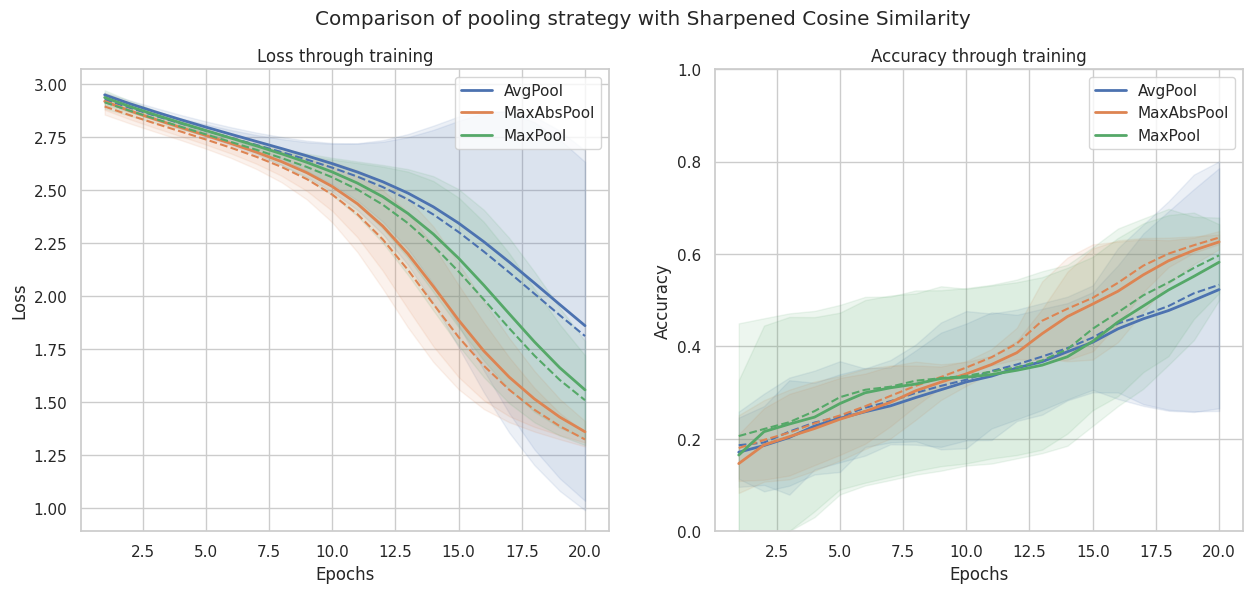

In [19]:
plot_comparison(result_pooling, title="Comparison of pooling strategy with Sharpened Cosine Similarity")

On voit que le réseau a du mal à rapidement converger : le learning rate est probablement trop faible. Les intervalles de confiance sont également très large, il faudrait probablement combiner à un learning rate plus fort plus d'observations pour lisser la courbe.

Si l'on considère la valeur moyenne, on remarque que les performances avec la couche MaxAbsPool semblent permettre un entraînement plus sain. A nouveau, il faudrait faire continuer l'entraînement un peu plus longtemps pour mesurer les performances long terme : il n'y a aucun indicateur qui nous dise que les performances maximale sont proches. Il n'y a pas eu non plus d'overfitting pour le moment.

Finalement, on ne peut pas vraiment parler de performance en terme d'accuracy parce que les hyperparamètres ne semblent pas être optimaux pour atteindre *rapidement* les meilleurs performances. Des réseaux convolutionnels équivalent atteignent de meilleurs performances (nous n'avons pas conservé cette partie d'étude dans ce notebook).


### Non-utilisation d'une fonction d'activation

Nous souhaitons maintenant mesurer les performances de ce même réseau, en intercalant des fonctions d'activations. Nous choisissons d'utiliser ReLU.

In [7]:
def generate_SCS_ReLU_model():
  regularizer = keras.regularizers.L2(l2=0.01)
  model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[28, 28, 1]),
    CosSim2D(filters=16, kernel_size=3, padding="same", kernel_initializer="he_normal"),
    keras.layers.ReLU(),
    pooling_layer(pool_size=2),

    CosSim2D(filters=8, kernel_size=3, padding="same", kernel_initializer="he_normal"),
    keras.layers.ReLU(),
    pooling_layer(pool_size=2),

    CosSim2D(filters=4, kernel_size=3, padding="same", kernel_initializer="he_normal"),
    keras.layers.ReLU(),
    pooling_layer(pool_size=2),

    keras.layers.Flatten(),
    keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizer),
    keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")
  ])
  return model

De nouveau, passons à la comparaison, nous réutiliserons les résultats de la comparaison précédente.

In [9]:
def train_model(model, learning_rate=1e-3, epochs=10, verbose=0):
  model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=learning_rate), metrics=["accuracy"])
  history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), verbose=verbose)
  return pd.DataFrame(history.history)

n_epochs = 20
learning_rate = 1e-3
comparisons_number = 3
results_relu = [{"type": "Without ReLU", "history": element["history"]} for element in result_pooling if element["type"] == "MaxAbsPool"]

print("Comparison", end=" ")
for index in range(comparisons_number):
  print(index+1, end="... ")
  model = generate_SCS_ReLU_model()
  history = train_model(model, learning_rate=learning_rate, epochs=n_epochs)
  result = {"type": "With ReLU", "history": history}
  results_relu.append(result)

Comparison 1... 2... 3... 

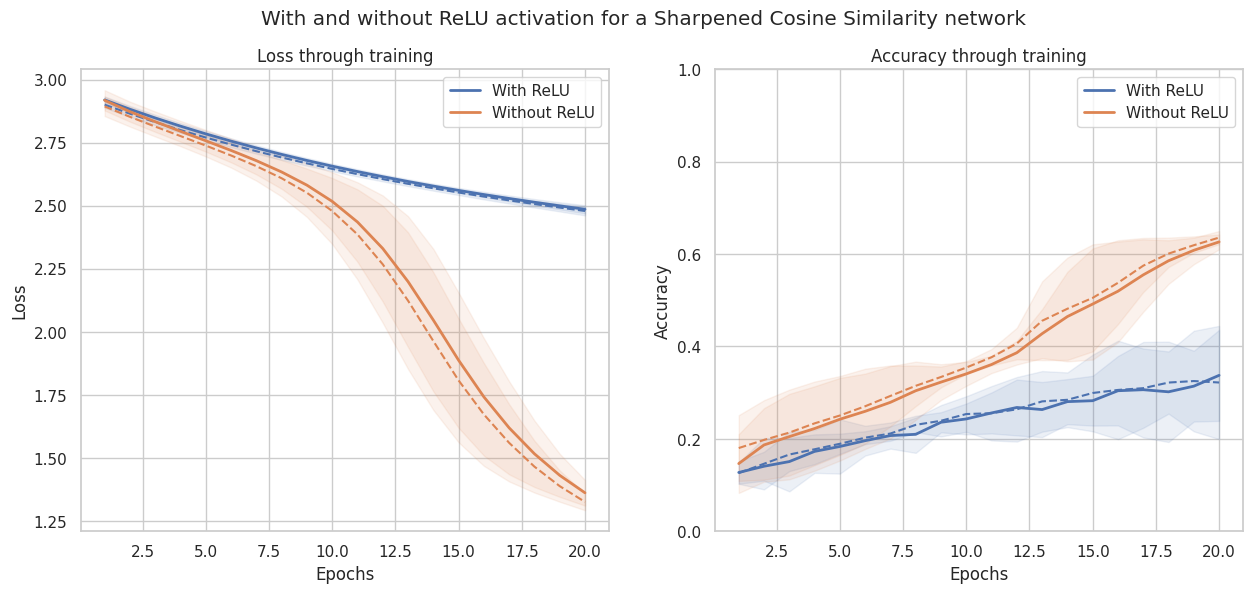

In [20]:
plot_comparison(results_relu, "With and without ReLU activation for a Sharpened Cosine Similarity network")

Nous pouvons faire les mêmes remarques que précédemment concernant la vitesse de convergence, donc notre comparaison peut à nouveau donner une tendance mais pas une vérité. Remarquons également que la comparaison gagnerait à être réalisé sur plus d'époques et réalisée plus de fois pour avoir des intervalles de confiance sur le *train* et la *validation* plus restreint.

On remarque cependant qu'il y a une très nette différence entre un réseau avec et sans activation ReLU. C'est une remarque que nous avons pu faire sur chaque utilisation et qui est partagée par la communauté.